In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import load_iris
from ml_tooling import Model
from ml_tooling.data import Dataset
from ml_tooling.baseclass import logger
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
class IrisData(Dataset):
    def load_training_data(self):
        data = load_iris()
        return pd.DataFrame(data=data.data, columns=data.feature_names), np.where(data.target == 1, 1, 0)
    
    def load_prediction_data(self, idx):
        X, y = self.load_training_data()
        
        return X.loc[idx, :].to_frame().T
    
data = IrisData()
data.create_train_test()

<IrisData - Dataset>

In [5]:
rf_clf = Model(RandomForestClassifier(n_estimators=10))

In [6]:
lr = Model(LogisticRegression())

In [7]:
lr.score_estimator(data)

[16:48:48] - Scoring estimator...
/home/anders/.pyenv/versions/3.7.4/envs/ml_tooling_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[16:48:48] - LogisticRegression - accuracy: 0.7368421052631579


<Result LogisticRegression: accuracy: 0.74>

In [8]:
rf_clf.config.RANDOM_STATE = 42

In [9]:
rf_clf.config

<Config: 
VERBOSITY: 0
CLASSIFIER_METRIC: accuracy
REGRESSION_METRIC: r2
CROSS_VALIDATION: 10
STYLE_SHEET: /home/anders/projects/ml_tooling/src/ml_tooling/almbrand.mplstyle
N_JOBS: -1
RANDOM_STATE: 42
RUN_DIR: /home/anders/projects/ml_tooling/notebooks/runs
ESTIMATOR_DIR: /home/anders/projects/ml_tooling/notebooks/models
LOG: False
>

In [10]:
result = rf_clf.score_estimator(data, metric='roc_auc', cv=10)

[16:48:59] - Scoring estimator...
[16:48:59] - Cross-validating...
[16:49:01] - RandomForestClassifier - roc_auc: 0.959375


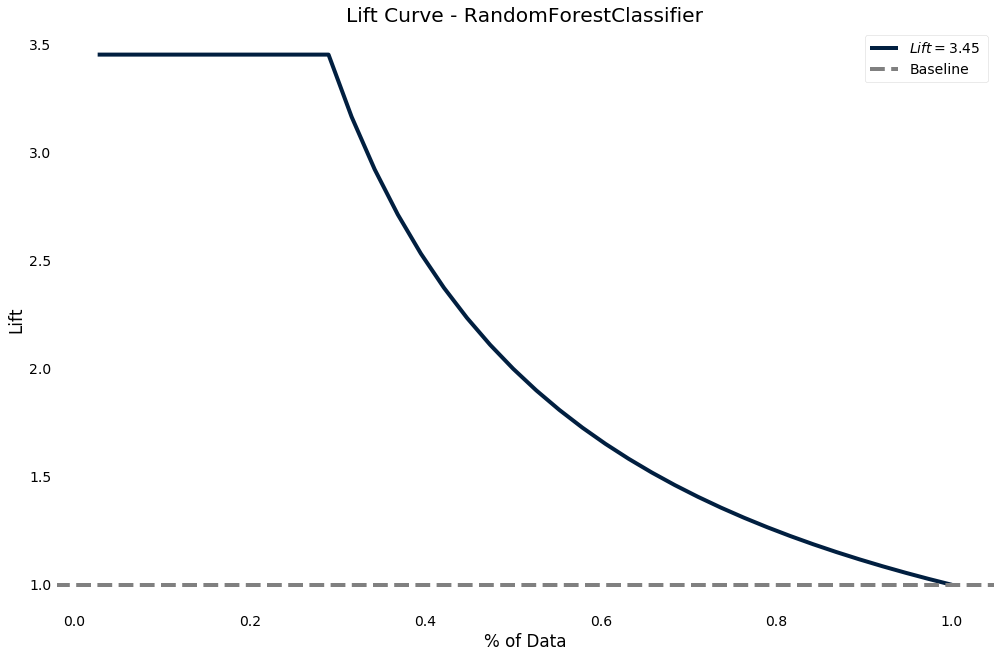

In [11]:
result.plot.lift_curve()

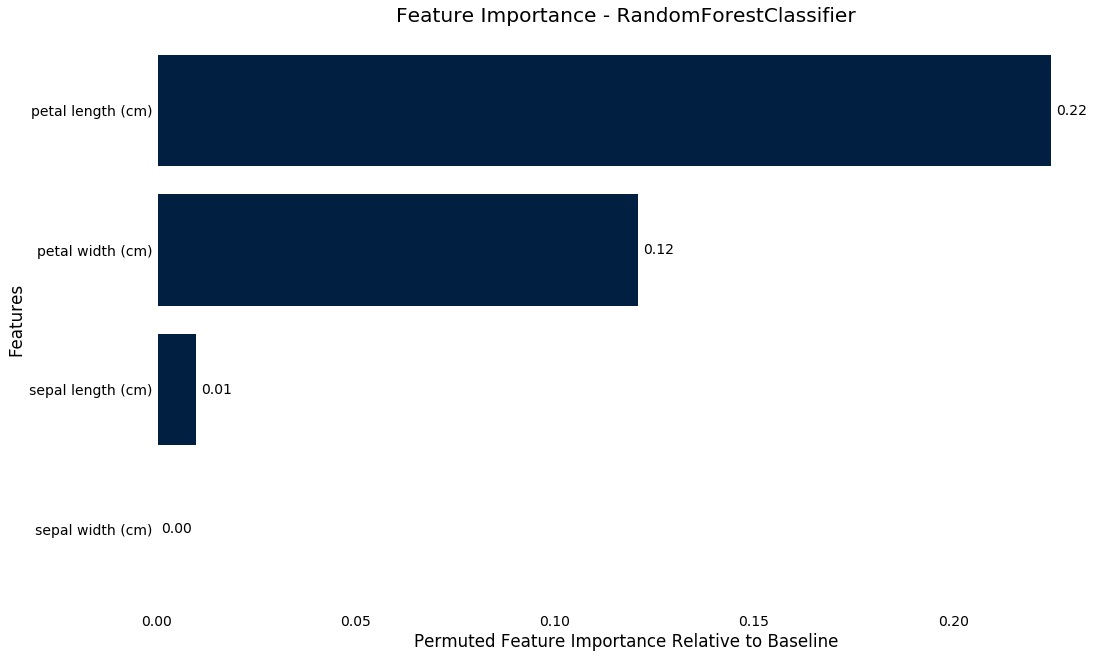

In [12]:
ax = result.plot.feature_importance(100)

In [14]:
with rf_clf.log('./gridsearch'):
    best_model, results = rf_clf.gridsearch(data, {"max_depth": [5, 10, 15]})

[16:49:16] - Starting gridsearch...
[16:49:16] - Done!
[16:49:16] - Saved run info at None


In [15]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
results.to_dataframe()

,bootstrap,class_weight,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,...,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start,score,metric,cross_val_std,cv
0,True,None,gini,15,auto,None,0.0,None,1,2,...,10,None,False,None,0,False,0.945303,accuracy,0.083469,10
1,True,None,gini,15,auto,None,0.0,None,1,2,...,10,None,False,None,0,False,0.945303,accuracy,0.083469,10
2,True,None,gini,15,auto,None,0.0,None,1,2,...,10,None,False,None,0,False,0.927121,accuracy,0.106109,10


In [17]:
with rf_clf.log('./test'):
    rf_clf.score_estimator(data)

[16:49:40] - Scoring estimator...
[16:49:40] - RandomForestClassifier - accuracy: 1.0
[16:49:40] - Saved run info at /home/anders/projects/ml_tooling/notebooks/runs/test/20191001/RandomForestClassifier_accuracy_1.000_1649.yaml


In [21]:
with rf_clf.log('./save'):
    rf_clf.save_estimator('./random_forest.pkl')

[16:50:27] - Saved estimator to random_forest.pkl


In [22]:
test_clf = Model.load_estimator('./random_forest.pkl')

[16:50:49] - Loaded RandomForestClassifier


In [23]:
test_clf.estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
test_clf.make_prediction(data, 19, proba=True)

,0,1
0,1.0,0.0


In [29]:
from sklearn.dummy import DummyClassifier

In [31]:
best_model, results = Model.test_estimators(data, [RandomForestClassifier(n_estimators=10), LogisticRegression(), DummyClassifier()], log_dir='')

[16:51:47] - Training estimator 1/3: <property object at 0x7f78cb4c6c50>
[16:51:47] - Scoring estimator...
[16:51:47] - RandomForestClassifier - accuracy: 1.0
[16:51:47] - Training estimator 2/3: <property object at 0x7f78cb4c6c50>
[16:51:47] - Scoring estimator...
/home/anders/.pyenv/versions/3.7.4/envs/ml_tooling_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[16:51:47] - LogisticRegression - accuracy: 0.7368421052631579
[16:51:47] - Training estimator 3/3: <property object at 0x7f78cb4c6c50>
[16:51:47] - Scoring estimator...
[16:51:47] - DummyClassifier - accuracy: 0.7105263157894737
[16:51:47] - Best estimator: RandomForestClassifier - accuracy: 1.0


In [32]:
results

[<Result RandomForestClassifier: accuracy: 1.0>
<Result LogisticRegression: accuracy: 0.74>
<Result DummyClassifier: accuracy: 0.71>]